In [1]:
import torch
import numpy as np
import networkx as nx
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.model_selection import cross_val_score, ShuffleSplit, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from datasets import load_dataset
from graph import process_dataset, centrality
from IPython.display import clear_output
from functools import partial
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

import sys

sys.path.append("../")

from thdc import hdv, bind, bundle, hdvsc, hdvw, ItemMemory

torch.set_default_device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def encode_graphe(graph, vertices, dimensions):
    for node in graph.nodes:
        if node not in vertices:
            vertices[node] = hdv(dimensions)

    Es = []

    for edge in graph.edges:
        Es.append(bind([vertices[edge[0]], vertices[edge[1]]]))

    return bundle(Es)


def encode_graphv(graph, vertices, dimensions):
    Vs = []

    for node in graph.nodes:
        if node not in vertices:
            vertices[node] = hdv(dimensions)
        Vs.append(vertices[node])

    return bundle(Vs)


class GraphHD(BaseEstimator, TransformerMixin):
    def __init__(self, dimensions, encoder):
        self.dimensions = dimensions
        self.vertices = dict()
        self.encoder = encoder

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        vs = []
        for x in X:
            vs.append(self.encoder(x, self.vertices, self.dimensions))
        return vs

In [3]:
def encode_graphew(graph, vertices, base):
    for node in graph.nodes:
        if node not in vertices:
            vertices[node] = hdvw(base, float(node))

    Es = []

    for edge in graph.edges:
        v1 = vertices[edge[0]]
        v2 = vertices[edge[1]]
        Es.append(bind([v1, v2]))

    return bundle(Es)


def encode_graphvw(graph, vertices, base):
    Vs = []

    for node in graph.nodes:
        if node not in vertices:
            vertices[node] = hdvw(base, float(node))
        Vs.append(vertices[node])

    return bundle(Vs)


class StochHD(BaseEstimator, TransformerMixin):
    def __init__(self, dimensions, encoder):
        self.dimensions = dimensions
        self.base = hdv(dimensions)
        self.encoder = encoder
        self.vertices = dict()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        vs = []
        for x in X:
            vs.append(self.encoder(x, self.vertices, self.base))
        return vs

In [4]:
def encode_graphvc(graph, vs):
    return bundle(list(map(lambda n: vs[round(float(n) * len(vs))], graph.nodes)))


class ConvHD(BaseEstimator, TransformerMixin):
    def __init__(self, vs, encoder):
        self.vs = vs
        self.encoder = encoder

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        vs = []
        for x in X:
            vs.append(self.encoder(x, self.vs))
        return vs

In [5]:
class BaseTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, rank, digits=5):
        self.rank = rank
        self.digits = digits

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        graphs = []
        for graph in X:
            gpr = self.rank(graph)
            nodes = dict()
            for key, value in gpr.items():
                nodes[key] = round(value, self.digits)
            H = nx.relabel_nodes(graph, nodes)
            graphs.append(H)
        return graphs


class BaseClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.memory = ItemMemory()

    def fit(self, X, y):
        for i in range(len(X)):
            self.memory.add_vector(y[i], X[i])
        return self

    def predict(self, X):
        p = []

        for query in X:
            p.append(self.memory.cleanup(query)[0])

        return p

In [6]:
# # encode_graphvc -> (graph, vs)
# N, DIMENSIONS = 10000, 10000

# vs = hdvsc(N, DIMENSIONS, side=500, iter=4)

In [7]:
# DATASET = load_dataset("graphs-datasets/MUTAG")["train"]
DATASET = load_dataset("graphs-datasets/PROTEINS")["train"]

In [8]:
(graphs, labels) = process_dataset(DATASET)

In [9]:
ALPHA = 0.65

transformers = {
    "pagerank": partial(nx.pagerank, alpha=ALPHA),
    "degree": nx.degree_centrality,
    "eigenvector": partial(nx.eigenvector_centrality_numpy),
    "katz": partial(nx.katz_centrality_numpy),
    "betweenness": partial(nx.betweenness_centrality),
    "closeness": partial(nx.closeness_centrality),
    "laplacian": partial(nx.laplacian_centrality),
    # "edge_current_flow": partial(nx.edge_current_flow_betweenness_centrality),
    # "current_flow": partial(nx.current_flow_closeness_centrality),
}

DIMENSIONS = 10000

encoders = {
    "graphhd_e": GraphHD(DIMENSIONS, encode_graphe),
    "graphhd_v": GraphHD(DIMENSIONS, encode_graphv),
    "stochhd_ew": StochHD(DIMENSIONS, encode_graphew),
    "stochhd_vw": StochHD(DIMENSIONS, encode_graphvw),
}

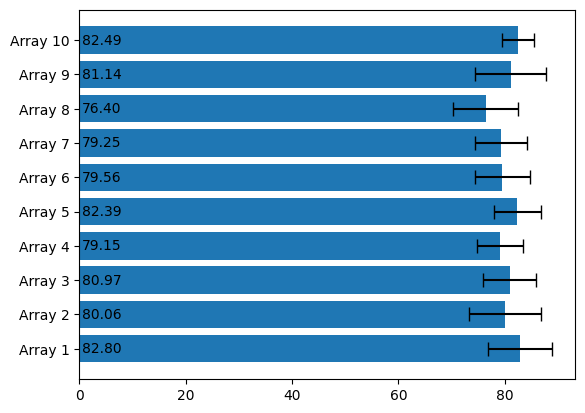

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

data = [np.random.normal(80, 5, 10) for _ in range(10)]
data_labels = [f"Array {i+1}" for i in range(10)]


def bars(data, labels):
    means = [np.mean(arr) for arr in data]
    std_devs = [np.std(arr) for arr in data]

    y = np.arange(len(means))

    plt.barh(y, means, xerr=std_devs, capsize=5, align="center")

    plt.yticks([i for i in range(len(means))], labels=labels)

    for i, value in enumerate(means):
        plt.text(0.5, y[i], f"{value:.2f}", va="center")

    # plt.tight_layout()
    plt.show()


bars(data, data_labels)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

data = np.random.rand(len(transformers), len(encoders))


def bars(data, tlabels, elabels):
    colormap = plt.get_cmap("tab10", len(elabels))

    y = np.arange(len(tlabels))

    bar_width = 0.2
    _, ax = plt.subplots(figsize=(12, 8))

    for i, encoder in enumerate(elabels):
        means = [np.mean(arr) for arr in data[i, :, :]]
        std_devs = [np.std(arr) for arr in data[i, :, :]]

        ax.barh(
            y - (i * bar_width),
            means,
            xerr=std_devs,
            capsize=1.5,
            height=bar_width,
            label=encoder,
            color=colormap(i),
        )

    y = y - bar_width * 1.5

    ax.set_yticks(y)
    ax.set_yticklabels(tlabels)
    ax.legend(title="Encoders", loc="upper right")

    plt.show()

In [12]:
FOLDS, REPS = 10, 3


def create_pipeline(encoder, transformer, graphs, labels, folds=5, reps=1):
    pipe = Pipeline(
        [
            ("transformer", BaseTransformer(transformer, digits=5)),
            ("encoder", encoder),
            ("classifier", BaseClassifier()),
        ]
    )
    scores = []
    for _ in range(reps):
        scores.extend(
            cross_val_score(
                pipe,
                graphs,
                labels,
                cv=ShuffleSplit(n_splits=folds),
                n_jobs=1,
                verbose=4,
                error_score="raise",
            )
        )

    return scores


def main():
    ascores = []

    for elabel, encoder in encoders.items():
        escores = []
        for tlabel, trans in transformers.items():
            scores = create_pipeline(encoder, trans, graphs, labels, FOLDS, REPS)
            print(elabel, tlabel)

            escores.append(scores)
        ascores.append(escores)

    return np.array(ascores)


sc2 = main()
bars(sc2, transformers.keys(), encoders.keys())

[CV] END ................................ score: (test=0.448) total time=  13.3s
[CV] END ................................ score: (test=0.524) total time=  12.2s
[CV] END ................................ score: (test=0.400) total time=  12.3s
[CV] END ................................ score: (test=0.371) total time=  12.1s
[CV] END ................................ score: (test=0.400) total time=  12.7s
[CV] END ................................ score: (test=0.429) total time=  12.9s
[CV] END ................................ score: (test=0.457) total time=  12.7s
[CV] END ................................ score: (test=0.457) total time=  12.7s
[CV] END ................................ score: (test=0.419) total time=  12.5s
[CV] END ................................ score: (test=0.448) total time=  12.4s
[CV] END ................................ score: (test=0.400) total time=  12.5s


KeyboardInterrupt: 

In [ ]:
print(sc)
bars(sc, encoders.keys(), transformers.keys())

In [ ]:
def conf():
    print("=> conf")
    pipe = Pipeline(
        [
            ("graphhd", GraphHD(DIMENSIONS, encode_graphv)),
            ("classifier", BaseClassifier()),
        ]
    )
    y_pred = cross_val_predict(pipe, graphs, labels, cv=FOLDS, n_jobs=1)
    print(accuracy_score(labels, y_pred))
    print(balanced_accuracy_score(labels, y_pred, adjusted=True))
    print(confusion_matrix(labels, y_pred))